In [198]:
import json
from typing import NamedTuple
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq
import pandas as pd

In [169]:
SAMPLING_RATE = 64 #Hz
LOW_FREQ = 0.5 #Hz
HIGH_FREQ = 5 #Hz
BVP_PEAK_THRESHOLD = 3
BVP_THRESHOLD = 20

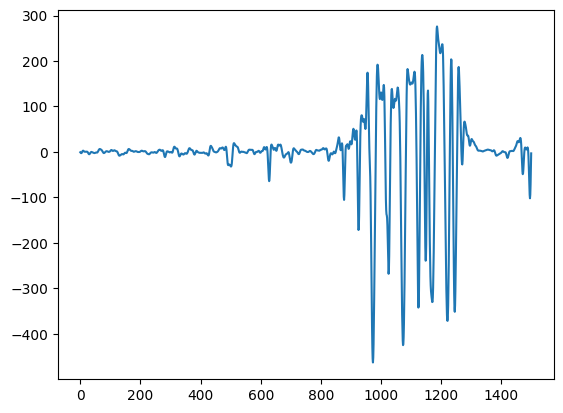

In [216]:
df = pd.read_csv('./../../recordings/empatica/gym_12kmh/BVP.csv', skiprows=2, header=None)
# df1 = pd.read_csv('./../../recordings/empatica/1hr_activity//HR.csv', skiprows=2, header=None)
# hr = df1[0].values
bvp = df[0].values
bvp = np.array(bvp)
bvp = bvp[4200:5700]
# bvp[bvp > BVP_THRESHOLD] = 0
# bvp[bvp < - BVP_THRESHOLD] = 0
plt.plot(bvp)

common_freq=1.3226666666666667, ibi=0.7560483870967742, hr=79.36


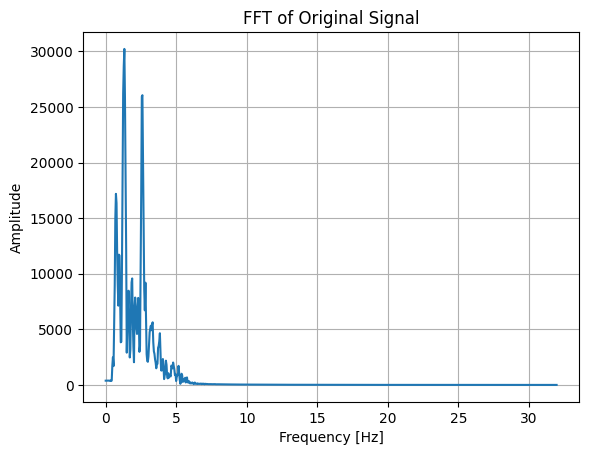

In [217]:
def bandpass_filter(signal_data, low_freq, high_freq, sampling_rate):
    nyquist_freq = 0.5 * sampling_rate
    low = low_freq / nyquist_freq
    high = high_freq / nyquist_freq
    order = 4  # Filter order
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal_data)
    return filtered_signal

filtered_bvp_signal = bandpass_filter(bvp, LOW_FREQ, HIGH_FREQ, sampling_rate=SAMPLING_RATE)

n = len(filtered_bvp_signal)
frequencies = fftfreq(n, 1/SAMPLING_RATE)
fft_values = fft(filtered_bvp_signal)
plt.plot(frequencies[:n//2], np.abs(fft_values[:n//2]))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('FFT of Original Signal')
plt.grid()

common_freq = frequencies[:n//2][np.abs(fft_values[:n//2]).argmax()]
ibi = 1 / common_freq
hr = 60 / ibi
print(f'{common_freq=}, {ibi=}, {hr=}')





